In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [3]:
gt = pd.read_csv("/content/drive/MyDrive/thesis/gt_cdc/merged_chlamydia.csv")
cdc = pd.read_csv("/content/drive/MyDrive/thesis/gt_cdc/Chlamydia_state_2018_2023.csv")

print(gt.head())
print(cdc.head())

         Date  Index State  FIPS
0  2018-01-01     93    AK     2
1  2018-01-01     87    AL     1
2  2018-01-01     86    AR     5
3  2018-01-01     91    AZ     4
4  2018-01-01     90    CA     6
   Indicator  Year   Geography  FIPS    Cases Rate per 100000  Population
0  Chlamydia  2023     Alabama     1   33,261           651.1   5,108,468
1  Chlamydia  2023      Alaska     2    5,117           697.7     733,406
2  Chlamydia  2023     Arizona     4   41,058           552.5   7,431,344
3  Chlamydia  2023    Arkansas     5   17,781           579.6   3,067,732
4  Chlamydia  2023  California     6  191,357           491.1  38,965,193


## Data Pre-process

In [4]:
# gt data pre-process

gt["Date"] = pd.to_datetime(gt["Date"])
gt["Year"] = gt["Date"].dt.year

gt_annual = (
    gt.groupby(["FIPS", "Year"])["Index"]
    .mean()
    .reset_index()
    .rename(columns={"Index": "GT_Index"})
)

In [5]:
print(gt_annual)

     FIPS  Year   GT_Index
0       1  2018  89.583333
1       1  2019  90.333333
2       1  2020  75.166667
3       1  2021  79.500000
4       1  2022  81.333333
..    ...   ...        ...
387    56  2021  60.250000
388    56  2022  56.166667
389    56  2023  50.916667
390    56  2024  58.083333
391    56  2025  55.444444

[392 rows x 3 columns]


In [11]:
# cdc data pre-process

cdc = cdc.rename(columns={
    "Geography": "State",
    "Rate per 100000": "CDC_Rate"
})
cdc = cdc[["FIPS", "State", "Year", "CDC_Rate"]]
cdc["CDC_Rate"] = pd.to_numeric(cdc["CDC_Rate"], errors="coerce")
cdc["FIPS"] = pd.to_numeric(cdc["FIPS"], errors="coerce").astype("Int64")

In [12]:
print(cdc.head(10))

   FIPS                 State  Year  CDC_Rate
0     1               Alabama  2023     651.1
1     2                Alaska  2023     697.7
2     4               Arizona  2023     552.5
3     5              Arkansas  2023     579.6
4     6            California  2023     491.1
5     8              Colorado  2023     435.1
6     9           Connecticut  2023     364.8
7    10              Delaware  2023     552.7
8    11  District of Columbia  2023    1228.0
9    12               Florida  2023     498.9


In [13]:
# merge
merged = pd.merge(cdc, gt_annual, on=["FIPS","Year"], how="inner")

In [14]:
print(merged.head())

   FIPS       State  Year  CDC_Rate   GT_Index
0     1     Alabama  2023     651.1  86.416667
1     2      Alaska  2023     697.7  66.416667
2     4     Arizona  2023     552.5  78.416667
3     5    Arkansas  2023     579.6  83.916667
4     6  California  2023     491.1  81.250000


In [15]:
print(merged[merged["FIPS"] == 24])

     FIPS     State  Year  CDC_Rate   GT_Index
20     24  Maryland  2023     579.8  78.500000
69     24  Maryland  2022     506.7  73.916667
118    24  Maryland  2021       NaN  74.000000
167    24  Maryland  2020     524.5  72.916667
216    24  Maryland  2019     624.9  88.416667
265    24  Maryland  2018     587.9  86.916667


## Analysis

In [16]:
pearson_corr = merged[["CDC_Rate","GT_Index"]].corr().iloc[0,1]
print(f"Overall Pearson correlation: {pearson_corr:.3f}")

Overall Pearson correlation: 0.333


In [33]:
state_corrs = (
    merged.dropna(subset=["CDC_Rate", "GT_Index"]).groupby("State").apply(lambda g: pd.Series(
        pearsonr(g["CDC_Rate"], g["GT_Index"]),
        index=["corr", "pval"]
    ), include_groups=False)
    .reset_index()
)

state_corrs["sig"] = state_corrs["pval"].apply(lambda p: "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ("+" if p < 0.1 else ""))))

print(state_corrs)

                   State      corr      pval  sig
0                Alabama  0.533562  0.275606     
1                 Alaska  0.734181  0.096598    +
2                Arizona  0.759093  0.080064    +
3               Arkansas  0.433952  0.389932     
4             California  0.971521  0.001205   **
5               Colorado  0.937748  0.005692   **
6            Connecticut  0.853580  0.030589    *
7               Delaware  0.945185  0.004425   **
8   District of Columbia  0.175341  0.739683     
9                Florida  0.779853  0.067362    +
10               Georgia  0.107707  0.839064     
11                Hawaii  0.830211  0.040795    *
12                 Idaho  0.628095  0.181750     
13              Illinois  0.879010  0.021072    *
14               Indiana  0.910640  0.011621    *
15                  Iowa  0.352180  0.493571     
16                Kansas  0.502568  0.309616     
17              Kentucky  0.886014  0.018749    *
18             Louisiana  0.878222  0.021342    *


In [35]:
treated_states = [
    "Alabama", "Arkansas", "Florida", "Georgia", "Idaho", "Indiana", "Iowa", "Kentucky",
    "Louisiana", "Mississippi", "Missouri", "Nebraska", "North Carolina", "Oklahoma",
    "South Carolina", "South Dakota", "Tennessee", "Texas", "West Virginia"
]

trigger_states = [
    "Arkansas", "Idaho", "Kentucky", "Louisiana",
    "Mississippi", "Oklahoma", "South Dakota", "Tennessee", "Texas"
]

state_corrs["group"] = "Control"
state_corrs.loc[state_corrs["State"].isin(treated_states), "group"] = "Treatment"
state_corrs.loc[state_corrs["State"].isin(trigger_states), "group"] = "Trigger Law"


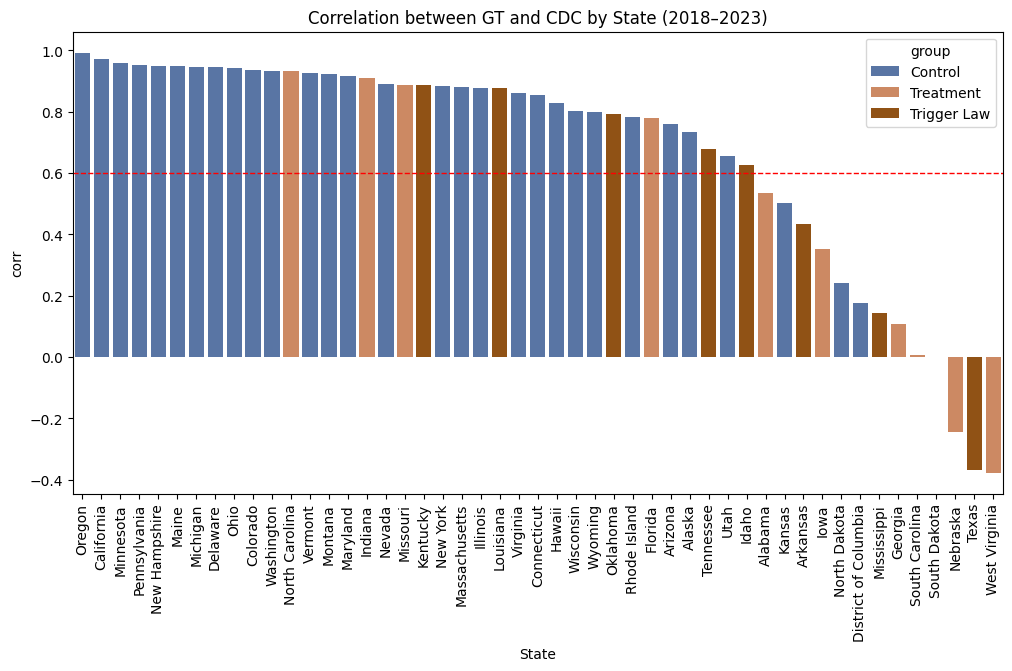

In [36]:
palette = {
    "Control": "#4C72B0",
    "Treatment": "#DD8452",
    "Trigger Law": "#A55200"
}

plt.figure(figsize=(12,6))
sns.barplot(data=state_corrs.sort_values("corr", ascending=False), x="State", y="corr", hue="group", dodge=False, palette=palette).axhline(0.6, color="red", linestyle="--", linewidth=1)
plt.xticks(rotation=90)
plt.title("Correlation between GT and CDC by State (2018–2023)")
plt.show()

### Regression

In [ ]:
# Pooled OLS
m1 = smf.ols("CDC_Rate ~ GT_Index", data=merged).fit(cov_type="HC1")

# State FE
m2 = smf.ols("CDC_Rate ~ GT_Index + C(State)", data=merged).fit(cov_type="HC1")

# Year FE
m3 = smf.ols("CDC_Rate ~ GT_Index + C(Year)", data=merged).fit(cov_type="HC1")

# Two-way FE
m4 = smf.ols("CDC_Rate ~ GT_Index + C(State) + C(Year)", data=merged).fit(cov_type="HC1")

In [ ]:
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     37.05
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           3.62e-09
Time:                        13:14:49   Log-Likelihood:                -1888.0
No. Observations:                 293   AIC:                             3780.
Df Residuals:                     291   BIC:                             3787.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.2154     73.573      0.982      0.3

In [ ]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     235.1
Date:                Fri, 03 Oct 2025   Prob (F-statistic):          8.25e-179
Time:                        13:14:49   Log-Likelihood:                -1443.3
No. Observations:                 293   AIC:                             2987.
Df Residuals:                     243   BIC:                             3171.
Df Model:                          49                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [ ]:
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     8.233
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           3.13e-08
Time:                        13:14:49   Log-Likelihood:                -1886.9
No. Observations:                 293   AIC:                             3788.
Df Residuals:                     286   BIC:                             3814.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -19.0473    155.221     

In [ ]:
print(m4.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     185.4
Date:                Fri, 03 Oct 2025   Prob (F-statistic):          6.84e-167
Time:                        13:14:49   Log-Likelihood:                -1424.1
No. Observations:                 293   AIC:                             2958.
Df Residuals:                     238   BIC:                             3161.
Df Model:                          54                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Plots


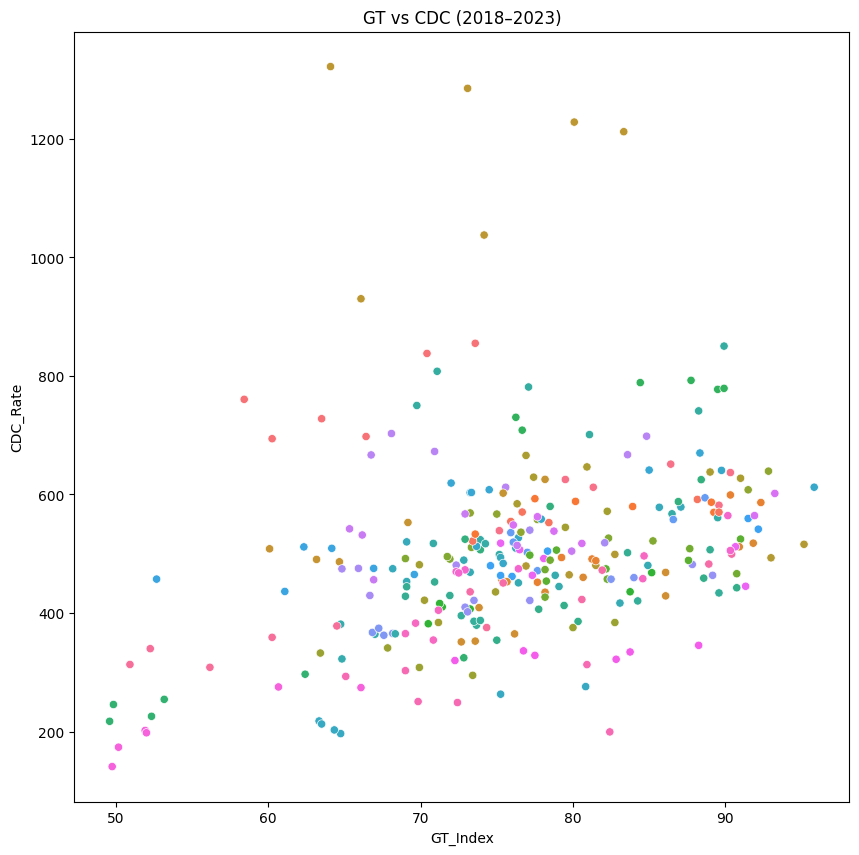

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=merged, x="GT_Index", y="CDC_Rate", hue="State", legend = False)
plt.title("GT vs CDC (2018–2023)")
plt.show()

## Placebo Test

I conducted a placebo test using the keyword *"coffee"*, which has no plausible link to STD incidence.  

In [ ]:
placebo = pd.read_csv("/content/drive/MyDrive/thesis/gt_cdc/merged_coffee.csv")

In [ ]:
placebo["Date"] = pd.to_datetime(placebo["Date"])
placebo["Year"] = placebo["Date"].dt.year

print(placebo.groupby("Year").nunique())

      Date  Index  State  FIPS
Year                          
2018    12     25      7     7
2019    12     22      7     7
2020    12     28      7     7
2021    12     22      7     7
2022    12     21      7     7
2023    12     24      7     7
2024    12     21      7     7
2025     8     20      7     7


In [ ]:
placebo_annual = (
    placebo.groupby(["FIPS", "Year"])["Index"]
    .mean()
    .reset_index()
    .rename(columns={"Index": "Coffee_Index"})
)

print(placebo_annual.head(20))

    FIPS  Year  Coffee_Index
0      6  2018     49.750000
1      6  2019     50.833333
2      6  2020     51.166667
3      6  2021     62.666667
4      6  2022     67.583333
5      6  2023     78.333333
6      6  2024     82.500000
7      6  2025     89.250000
8     12  2018     45.416667
9     12  2019     46.750000
10    12  2020     51.333333
11    12  2021     61.750000
12    12  2022     66.333333
13    12  2023     74.500000
14    12  2024     78.583333
15    12  2025     89.625000
16    17  2018     49.750000
17    17  2019     49.833333
18    17  2020     53.416667
19    17  2021     62.916667


In [ ]:
plb_merged = pd.merge(cdc, placebo_annual, on=["FIPS","Year"], how="inner")

print(plb_merged.head())
print(plb_merged.groupby("State")["Year"].nunique())

   FIPS       State  Year  CDC_Rate  Coffee_Index
0     6  California  2023     491.1     78.333333
1    12     Florida  2023     498.9     74.500000
2    17    Illinois  2023     557.7     75.416667
3    36    New York  2023     558.4     77.416667
4    48       Texas  2023     491.9     76.500000
State
California    6
Florida       6
Illinois      6
New York      6
Texas         6
Washington    6
Wyoming       6
Name: Year, dtype: int64


In [ ]:
plb_state_corrs = (
    plb_merged.groupby("State")
    .apply(lambda g: pd.Series(
        pearsonr(g["CDC_Rate"], g["Coffee_Index"]),
        index=["corr", "pval"]
    ), include_groups=False)
    .reset_index()
)

print(plb_state_corrs)

        State      corr      pval
0  California -0.468999  0.348082
1     Florida -0.129081  0.807454
2    Illinois -0.540707  0.267981
3    New York -0.253750  0.627544
4       Texas  0.439771  0.382869
5  Washington -0.778611  0.068094
6     Wyoming -0.889070  0.017776
